In [1]:
raw<-read.table(file="./Bioskryb_DNA_final_summary.txt",header=T)
variant_anno<-read.csv(file="../../variant_annotation/780_variant_annotation_by_all_samples.csv",header=T)

In [2]:
raw$BINARY<-0
raw$BINARY[raw$NORMAL_UPPER_CI<raw$LOWER_CI ]<-1
#raw$BINARY[raw$NORMAL_UPPER_CI>=raw$LOWER_CI | raw$LOWER_CI<=0.05]<-0
length(unique((raw[raw$BINARY==1,]$CHROM.POS.REF.ALT)))

[1] 1187

In [3]:
length(((raw[raw$BINARY==1,]$CHROM.POS.REF.ALT)))

[1] 53919

# Oncoplot

In [4]:
blacklist<-read.table(file="../blacklist_variants.csv",header=F)
filtered2 <- subset(raw, BINARY %in% c(1) &
                   #Mosaic_shared_btw_WGS_Amp==1 &
                   !(CHROM.POS.REF.ALT %in% blacklist$V1) & 
                   CHROM.POS.REF.ALT %in% variant_anno[variant_anno$R==1,]$variant_list &
                   Cell_Type %in% c("ExN","InN") & PLATE %in% c("PL01","PL02"))

# MV recurrency calculation
recurrency<-data.frame(t(matrix(ncol=length(unique(filtered2$CHROM.POS.REF.ALT)))))
colnames(recurrency)<-"Recurrency"
recurrency$variant<-unique(filtered2$CHROM.POS.REF.ALT)
rownames(recurrency)<-unique(filtered2$CHROM.POS.REF.ALT)
for (i in unique(filtered2$CHROM.POS.REF.ALT)){
    recurrency[i,1]<-nrow(subset(filtered2, CHROM.POS.REF.ALT==i))
}

# filter out high AF MVs
filtered2<-subset(filtered2, CHROM.POS.REF.ALT %in% recurrency[recurrency$Recurrency<15 & recurrency$Recurrency>2,]$variant)
filtered<-filtered2

In [5]:
print(paste("variant number :",length(unique(filtered[filtered$BINARY==1,]$CHROM.POS.REF.ALT))))
print(paste("detection event :",length(((filtered[filtered$BINARY==1,]$CHROM.POS.REF.ALT)))))

[1] "variant number : 41"
[1] "detection event : 256"


In [6]:
recurrency$Recurrency
sorted_recurrency<-sort(recurrency[recurrency$Recurrency<15 & recurrency$Recurrency>2,]$Recurrency,decreasing=T)
sorted_recurrency
sum(sorted_recurrency)

[1]   2 126 137  64  66   4  32  10   8  12  76  53  54 141  30  30  12  11
 [19]  97   1   1  14  12  25  19  19  40  22  12   3   8   3  32  37  25  29
 [37]   1   3  29  22   1  30  24  19  19   9   1   2   7  20   1   9   3   4
 [55]   2   2   2   1   1   1   4   2   2   3  20   1   1   9   2   3   3   3
 [73]   5   1   1   4   1   2   1   1   2   1   2   2   1   2   3   1   2   1
 [91]   1   1   3   1   1   2   4   1  22   2  11   1   1   1   3   1   2   1
[109]   1   1   3   1   7   8   7   7   7   5   1   2   1   1   4   1   3   2
[127]   1   2   3   1   2   1   2   2   1   1   2   1   1   1   1   1   1   1
[145]   1   2   1   1   1   1   2   1   2   1   1   1

[1] 14 12 12 12 12 11 11 10  9  9  9  8  8  8  7  7  7  7  7  5  5  4  4  4  4
[26]  4  4  3  3  3  3  3  3  3  3  3  3  3  3  3  3

[1] 256

In [7]:
# F_variant_freq<-sorted_recurrency[c(9,18,23,26,28,29,37,38,40)]
# T_variant_freq<-sorted_recurrency[c(13,15,16,17,19,20,25,32,41)]

In [27]:
set.seed(123)
cell_number<-118
df<-as.data.frame(t(matrix(ncol=0,nrow=118)))
temp2<-c()
for (j in 1:10000){
    for (i in 1:length(sorted_recurrency)){
        vector <- rep(0, cell_number)
        # Choose 10 random positions to place ones
        random_positions <- sample(1:cell_number, sorted_recurrency[i])
        vector[random_positions] <- 1
        
        # Place ones in the chosen random positions
        if (sum(random_positions[random_positions>=57])==0 & sum(random_positions[random_positions>=17])!=0){
            df<-rbind(df,vector)
        }
        if (sum(random_positions[random_positions<57])==0 & sum(random_positions[random_positions>=74])!=0){
            df<-rbind(df,vector)
        }
    }
    temp2[j]<-length(which(colSums(df[,c(1:16)])>0))+length(which(colSums(df[,c(57:73)])>0))
    df<-as.data.frame(t(matrix(ncol=0,nrow=118)))
}

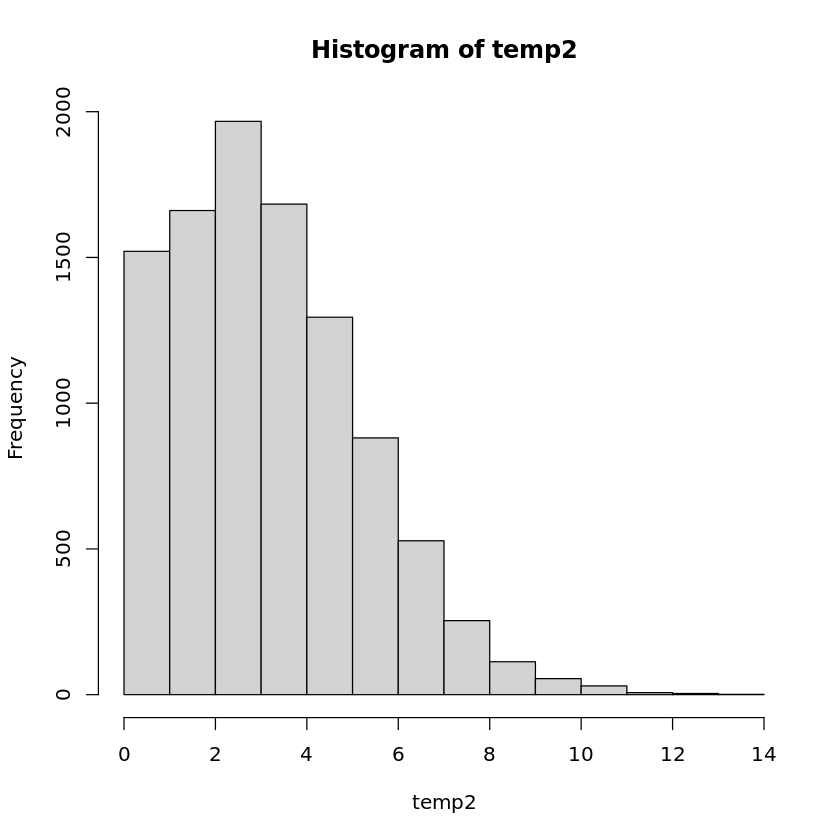

In [28]:
hist(temp2)

In [29]:
print(paste("Among 33 interneurons, the probability to have more than or equal to 15 interneurons sharing variants with local excitatory neurons:",(length(temp2[temp2>=15])/length(temp2))))

[1] "Among 33 interneurons, the probability to have more than or equal to 15 interneurons sharing variants with local excitatory neurons: 0"


In [30]:
(length(temp2[temp2>=15])/length(temp2))*100

[1] 0

In [31]:
pdf(file="ResolveOME_DNA2_6_permutation_histogram.pdf",height=5,width=5)
hist(temp2)
dev.off()

png 
  2